In [155]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import torch.nn.functional as F
import cv2
import numpy as np
import torch.utils.data as Data
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')

blank = cv2.imread('blank_28x28.png')
b = np.array(blank,dtype=np.float32)
b = torch.from_numpy(b)
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 100
learning_rate = 1e-7

img_transform = transforms.Compose([
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

from PIL import  Image,ImageDraw
import numpy as np


data1 = []
data2= []

img = Image.new('RGB', (28, 28), color = 'white')
row,col,ch= np.shape(img)
mean = 0
var = 1
sigma = var**0.5
gauss = np.random.normal(mean,sigma,(row,col,ch))
noisy = img + gauss


for i in range(20000):
    im_2 = Image.fromarray(noisy,'RGB')
    r = np.random.randint(1,101)
    draw = ImageDraw.Draw(im_2)
    if r%2==0:
        draw.rectangle([9,12,12,15],fill='red',outline='red')
        data1.append(np.asarray(im_2))
    else:
        draw.rectangle([21, 12, 24, 15], fill='red', outline='red')
        data1.append(np.asarray(im_2))
        

im_2.show()
for i in range(20000):
    im2 = Image.fromarray(noisy,'RGB')
    r = np.random.randint(1,101)
    draw = ImageDraw.Draw(im2)
    if r%2==0:
        draw.rectangle([21, 12, 24, 15], fill='red', outline='red')
        data2.append(np.asarray(im2))
    else:
        draw.rectangle([9,12,12,15],fill='red',outline='red')
        data2.append(np.asarray(im2))

im2.show()
y0 = np.array(data1, dtype=np.float32)
y1 = np.array(data2, dtype=np.float32)
y0 = np.transpose(y0, (0, 3, 2, 1))# This to make channels first for CNN
y1 = np.transpose(y1, (0, 3, 2, 1)) 


print(y0.shape)

x = torch.from_numpy(y0)
y = torch.from_numpy(y1)



torch_dataset = Data.TensorDataset(x,y)


loader = Data.DataLoader(

    dataset=torch_dataset,

    batch_size=250,

    shuffle=True,

    num_workers=0,

)

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True), # b, 8, 2, 2
            nn.Conv2d(8,4,3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(4,2,3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1,2)
        x = self.fc(x)
        return x

class auto_decoder(nn.Module):
    def __init__(self):
        super(auto_decoder,self).__init__()
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 3,padding=1)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 3,padding=1)
        
    def forward(self, x):
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x
    

model = autoencoder()


def h_score(fx, gy):
 
    fx = fx - fx.mean(0)

    gy = gy - gy.mean(0)

    Nsamples = fx.size(0)

    covf = torch.matmul((fx.t()), fx) / Nsamples

    covg = torch.matmul((gy.t()), (gy)) / Nsamples

    h = -2 * torch.mean((fx * gy).sum(1)) + (covf * covg).sum()

    return h

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

model_1 = auto_decoder()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=learning_rate,
                             weight_decay=1e-5)


for epoch in range(num_epochs):
    for x,y in loader:

        # ===================forward=====================
        #loss = criterion(output1, img)
        loss = h_score(model(x),model(y))
        # ===================backward====================
        optimizer.zero_grad()
        #optimizer_1.zero_grad()
        loss.backward()
        optimizer.step()
        #optimizer_1.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.item()))
    print("x: ", model(x[0].reshape(1,3,28,28)))
    print("y:", model(y[0].reshape(1,3,28,28)))

    print("b:", model(b.reshape(1,3,28,28)))



torch.save(model.state_dict(), './conv_autoencoder.pth')

(20000, 3, 28, 28)
epoch [1/100], loss:0.0027
x:  tensor([[1.1401]], grad_fn=<AddmmBackward>)
y: tensor([[1.1401]], grad_fn=<AddmmBackward>)
b: tensor([[1.0202]], grad_fn=<AddmmBackward>)
epoch [2/100], loss:-0.0011
x:  tensor([[1.1396]], grad_fn=<AddmmBackward>)
y: tensor([[1.1396]], grad_fn=<AddmmBackward>)
b: tensor([[1.0198]], grad_fn=<AddmmBackward>)
epoch [3/100], loss:0.0025
x:  tensor([[1.1391]], grad_fn=<AddmmBackward>)
y: tensor([[1.1391]], grad_fn=<AddmmBackward>)
b: tensor([[1.0194]], grad_fn=<AddmmBackward>)
epoch [4/100], loss:-0.0004
x:  tensor([[1.4081]], grad_fn=<AddmmBackward>)
y: tensor([[1.4081]], grad_fn=<AddmmBackward>)
b: tensor([[1.0190]], grad_fn=<AddmmBackward>)
epoch [5/100], loss:0.0014
x:  tensor([[1.1383]], grad_fn=<AddmmBackward>)
y: tensor([[1.4075]], grad_fn=<AddmmBackward>)
b: tensor([[1.0186]], grad_fn=<AddmmBackward>)
epoch [6/100], loss:-0.0014
x:  tensor([[1.4068]], grad_fn=<AddmmBackward>)
y: tensor([[1.1379]], grad_fn=<AddmmBackward>)
b: tensor([

epoch [50/100], loss:-0.0002
x:  tensor([[1.3784]], grad_fn=<AddmmBackward>)
y: tensor([[1.1192]], grad_fn=<AddmmBackward>)
b: tensor([[1.0007]], grad_fn=<AddmmBackward>)
epoch [51/100], loss:0.0006
x:  tensor([[1.3777]], grad_fn=<AddmmBackward>)
y: tensor([[1.1188]], grad_fn=<AddmmBackward>)
b: tensor([[1.0003]], grad_fn=<AddmmBackward>)
epoch [52/100], loss:-0.0007
x:  tensor([[1.3770]], grad_fn=<AddmmBackward>)
y: tensor([[1.1183]], grad_fn=<AddmmBackward>)
b: tensor([[0.9998]], grad_fn=<AddmmBackward>)
epoch [53/100], loss:-0.0001
x:  tensor([[1.1179]], grad_fn=<AddmmBackward>)
y: tensor([[1.3764]], grad_fn=<AddmmBackward>)
b: tensor([[0.9995]], grad_fn=<AddmmBackward>)
epoch [54/100], loss:0.0000
x:  tensor([[1.3757]], grad_fn=<AddmmBackward>)
y: tensor([[1.3757]], grad_fn=<AddmmBackward>)
b: tensor([[0.9990]], grad_fn=<AddmmBackward>)
epoch [55/100], loss:0.0007
x:  tensor([[1.3752]], grad_fn=<AddmmBackward>)
y: tensor([[1.1171]], grad_fn=<AddmmBackward>)
b: tensor([[0.9987]], gr

epoch [99/100], loss:0.0018
x:  tensor([[1.3487]], grad_fn=<AddmmBackward>)
y: tensor([[1.3487]], grad_fn=<AddmmBackward>)
b: tensor([[0.9821]], grad_fn=<AddmmBackward>)
epoch [100/100], loss:0.0012
x:  tensor([[1.3481]], grad_fn=<AddmmBackward>)
y: tensor([[1.0989]], grad_fn=<AddmmBackward>)
b: tensor([[0.9818]], grad_fn=<AddmmBackward>)


In [114]:
blank = cv2.imread('blank_28x28.png')
b = blank.astype('float32')
b = torch.from_numpy(b)

for i in range(5):
    print("x: ", model(x[i].reshape(1,3,28,28)))
    print("y:", model(y[i].reshape(1,3,28,28)))

print("b:", model(b.reshape(1,3,28,28)))


x:  tensor([[1.3537]], grad_fn=<AddmmBackward>)
y: tensor([[1.3537]], grad_fn=<AddmmBackward>)
x:  tensor([[1.2196]], grad_fn=<AddmmBackward>)
y: tensor([[1.3537]], grad_fn=<AddmmBackward>)
x:  tensor([[1.3537]], grad_fn=<AddmmBackward>)
y: tensor([[1.3537]], grad_fn=<AddmmBackward>)
x:  tensor([[1.2196]], grad_fn=<AddmmBackward>)
y: tensor([[1.2196]], grad_fn=<AddmmBackward>)
x:  tensor([[1.2196]], grad_fn=<AddmmBackward>)
y: tensor([[1.2196]], grad_fn=<AddmmBackward>)
b: tensor([[0.1682]], grad_fn=<AddmmBackward>)


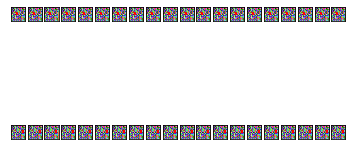

In [115]:
import matplotlib.pyplot as plt
for index in range(20):
    # display original
    ax = plt.subplot(2, 20, index + 1)
    plt.imshow(Image.fromarray(data1[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 20, index + 1 + 20)
    plt.imshow(Image.fromarray(data2[-i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [116]:
for i in range(20):
    img = Image.new('RGB', (28, 28), color = 'white')
    row,col,ch= np.shape(img)
    mean = 0
    var = 1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    noisy = img + gauss
    im2 = Image.fromarray(noisy,'RGB')
    b = np.asarray(im2)
    b = np.array(b, dtype=np.float32)
    b = torch.from_numpy(b)
    print("b:", model(b.reshape(1,3,28,28)))
    print("x: ", model(x[i].reshape(1,3,28,28)))
    print("y:", model(y[i].reshape(1,3,28,28)))

b: tensor([[0.5879]], grad_fn=<AddmmBackward>)
x:  tensor([[1.3537]], grad_fn=<AddmmBackward>)
y: tensor([[1.3537]], grad_fn=<AddmmBackward>)
b: tensor([[1.0701]], grad_fn=<AddmmBackward>)
x:  tensor([[1.2196]], grad_fn=<AddmmBackward>)
y: tensor([[1.3537]], grad_fn=<AddmmBackward>)
b: tensor([[0.6711]], grad_fn=<AddmmBackward>)
x:  tensor([[1.3537]], grad_fn=<AddmmBackward>)
y: tensor([[1.3537]], grad_fn=<AddmmBackward>)
b: tensor([[0.6640]], grad_fn=<AddmmBackward>)
x:  tensor([[1.2196]], grad_fn=<AddmmBackward>)
y: tensor([[1.2196]], grad_fn=<AddmmBackward>)
b: tensor([[0.9824]], grad_fn=<AddmmBackward>)
x:  tensor([[1.2196]], grad_fn=<AddmmBackward>)
y: tensor([[1.2196]], grad_fn=<AddmmBackward>)
b: tensor([[0.3892]], grad_fn=<AddmmBackward>)
x:  tensor([[1.3537]], grad_fn=<AddmmBackward>)
y: tensor([[1.2196]], grad_fn=<AddmmBackward>)
b: tensor([[0.8569]], grad_fn=<AddmmBackward>)
x:  tensor([[1.2196]], grad_fn=<AddmmBackward>)
y: tensor([[1.2196]], grad_fn=<AddmmBackward>)
b: ten

In [121]:
for i in range(3):
    img = Image.new('RGB', (28, 28), color = 'white')
    row,col,ch= np.shape(img)
    mean = 0
    var = 1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    noisy = img + gauss
    im2_n = Image.fromarray(noisy,'RGB')
    b = np.asarray(im2_n)
    b = np.array(b, dtype=np.float32)
    b = torch.from_numpy(b)
    im2_test = Image.fromarray(noisy,'RGB')
    draw1 = ImageDraw.Draw(im2_test)
    draw1.rectangle([21, 12, 24, 15], fill='red', outline='red')
    z = np.asarray(im2_test)
    z = np.array(z, dtype=np.float32)
    z = torch.from_numpy(z)
    print("b:", model(b.reshape(1,3,28,28)))
    print("z: ", model(z.reshape(1,3,28,28)))
    print("x: ", model(x[i].reshape(1,3,28,28)))
    print("y:", model(y[i].reshape(1,3,28,28)))
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("  ")
    p = Image.fromarray(data1[i])
    #p.show()
    q = Image.fromarray(data2[i])
    #q.show()
    
im2_test.show()

b: tensor([[1.2100]], grad_fn=<AddmmBackward>)
z:  tensor([[1.0805]], grad_fn=<AddmmBackward>)
x:  tensor([[1.3537]], grad_fn=<AddmmBackward>)
y: tensor([[1.3537]], grad_fn=<AddmmBackward>)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
  
b: tensor([[0.7304]], grad_fn=<AddmmBackward>)
z:  tensor([[0.7477]], grad_fn=<AddmmBackward>)
x:  tensor([[1.2196]], grad_fn=<AddmmBackward>)
y: tensor([[1.3537]], grad_fn=<AddmmBackward>)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
  
b: tensor([[0.7865]], grad_fn=<AddmmBackward>)
z:  tensor([[0.9079]], grad_fn=<AddmmBackward>)
x:  tensor([[1.3537]], grad_fn=<AddmmBackward>)
y: tensor([[1.3537]], grad_fn=<AddmmBackward>)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
  
